# Mounts and Imports

In [1]:
# Mounting Google Drive
from google.colab import drive, output, files
drive.mount('/content/drive')

Mounted at /content/drive


In [472]:
# Main Imports
import scipy.io as sio
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # Used to create confusion heatmaps
import pywt                     # Used to perform wavelet transform
import os

# Classifier imports
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# Utils import
!cp /content/drive/MyDrive/Grasp\ Project\ /Data\ /Our\ Model\ [External\ Data\ Analysis/utils_babyscript.py /content
import utils_babyscript as ut

import importlib
importlib.reload(ut)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<module 'utils_babyscript' from '/content/utils_babyscript.py'>

In [4]:
labels = {1: 'Large Diameter Grasp', 2: 'Small Diameter Grasp (power grip)',
          3: 'Fixed Hook Grasp', 4: 'Index Finger Extension Grasp', 5:
          'Medium Wrap', 6: 'Ring Grasp', 7: 'Prismatic Four Fingers Grasp',
          8: 'Stick Grasp', 9: 'Writing Tripod Grasp', 10: 'Power Sphere Grasp',
          11: 'Three Finger Sphere Grasp', 12: 'Precision Sphere Grasp', 13:
          'Tripod Grasp', 14: 'Prismatic Pinch Grasp', 15: 'Tip Pinch Grasp',
          16: 'Quadpod Grasp', 17: 'Lateral Grasp', 18: 'Parallel Extension Grasp',
          19: 'Extension Type Grasp', 20: 'Power Disk Grasp', 21: 'Open a Bottle with a Tripod Grasp',
          22: 'Turn a Screw', 23: 'Cut Something'}

# Load and Process Sample Subject EMG Data

In [454]:
# Loads MATLAB file for Subject 1
subject1_file_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1/Subject_1/S1_A1_E3.mat'
subject1_file_dict = sio.loadmat(subject1_file_path)

In [455]:
# Process EMG data for subject 1 by converting it to a Pandas dataframe
sampling_rate = 100
_, subject1_emg_dataframe = ut.process_ninapro_subject(subject1_file_path, sampling_rate)

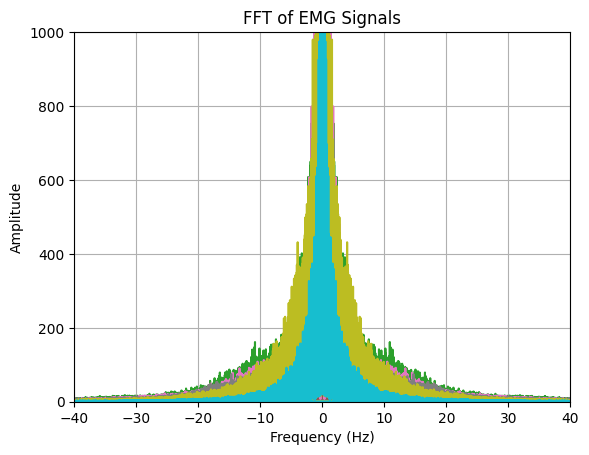

In [7]:
# Perform FFT on emg signal.

from scipy.fft import fft, fftfreq

# Get the EMG data as a numpy array
emg_data = subject1_emg_dataframe.iloc[:, 1:].values
num_samples, num_channels = emg_data.shape

# Calculate the FFT for each channel
emg_fft = fft(emg_data, axis=0)

# Calculate the corresponding frequencies
frequencies = fftfreq(num_samples, 1 / sampling_rate)

# Plot the FFT results
plt.figure()
for i in range(num_channels):
    plt.plot(frequencies, np.abs(emg_fft[:, i]))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of EMG Signals')
plt.grid(True)
plt.ylim(0, 1000)  # Set y-axis limit
plt.xlim(-40, 40)
plt.show()

EMG Rectifying and Smoothening Filter

In [456]:
# Remove and save time column
time_data = subject1_emg_dataframe['Time'].reset_index(drop=True)
emg_data = subject1_emg_dataframe.drop(columns='Time').reset_index(drop=True)
emg_columns = emg_data.columns

# Rectify signal
emg_data_rectified = emg_data.abs()

# Low-pass envelope with a cutoff frequency of 6 Hz
low_cutoff = 10
nyq = 0.5 * sampling_rate
b, a = scipy.signal.butter(2, low_cutoff / nyq, btype='low')
emg_data_filtered = pd.DataFrame(scipy.signal.filtfilt(b, a, emg_data_rectified.values, axis=0), columns=emg_columns)

# Method 1: Pandas rolling mean

In [460]:
def rolling_rms(dataframe, window_size):
  # Square the signal values
  squared_signal = dataframe ** 2

  # Calcualte the rolling mean of the squared values
  rolling_mean = squared_signal.rolling(window=window_size).mean()

  # Find the final RMS envelope
  rms_signal = np.sqrt(rolling_mean)

  return rms_signal

rms_emg_signal_pandas = rolling_rms(emg_data, 25)

In [461]:
# Reinstall time column
rms_emg_signal_pandas.insert(0, 'Time', time_data)

In [444]:
print(type(rms_emg_signal_pandas))
print('Length of original signal: ', len(emg_data_filtered))
print('Length of RMS signal: ', len(rms_emg_signal_pandas))

<class 'pandas.core.frame.DataFrame'>
Length of original signal:  227493
Length of RMS signal:  227493


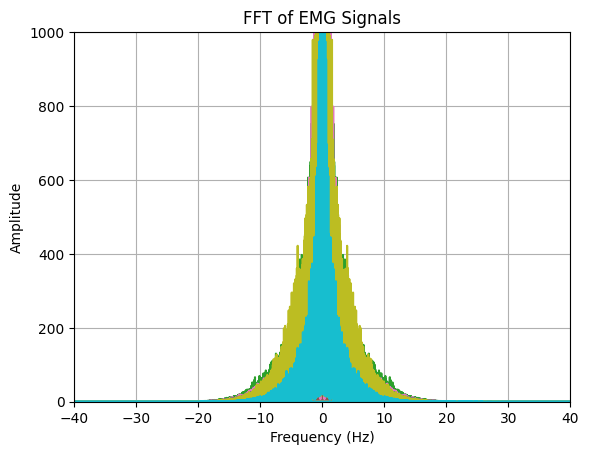

In [445]:
# Perform FFT again on EMG signal
# Get the EMG data as a numpy array
emg_data = emg_data_filtered.iloc[:, 1:].values
num_samples, num_channels = emg_data.shape

# Calculate the FFT for each channel
emg_fft = fft(emg_data, axis=0)

# Calculate the corresponding frequencies
frequencies = fftfreq(num_samples, 1 / sampling_rate)

# Plot the FFT results
plt.figure()
for i in range(num_channels):
    plt.plot(frequencies, np.abs(emg_fft[:, i]))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of EMG Signals')
plt.grid(True)
plt.ylim(0, 1000)  # Set y-axis limit
plt.xlim(-40, 40)
plt.show()

In [465]:
# Normalize data

def normalize_emg_data(filtered_dataframe):
  normalized_dataframe = pd.DataFrame(index=filtered_dataframe.index)
  for column in filtered_dataframe.columns:
    if column == 'Time':
      normalized_dataframe[column] = filtered_dataframe[column]
      continue
    # Drop any NaNs
    filtered_df_nonans = filtered_dataframe.dropna(subset=[column])
    # Find minimum and maximum (95th percentile)
    column_min =filtered_df_nonans[column].min()
    column_max = np.percentile(filtered_df_nonans[column], 95)
    if column_max == column_min:
      normalized_dataframe[column] = 0
    else:
      normalized_dataframe[column] = (filtered_dataframe[column] - column_min) / (column_max - column_min)
  return normalized_dataframe

normalized_rms = normalize_emg_data(rms_emg_signal_pandas)

In [466]:
# Segment the data based on restim data (for ML only)
subject1_restim_data = subject1_file_dict['restimulus']
restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject1_restim_data)
restim_emg_data_pandas = ut.segment_data(normalized_rms, restim_timestamps)

# Segment the data based on stimulus data (for visualization only)
subject1_stimulus_data = subject1_file_dict['stimulus']
stim_timestamps, stim_labels = ut.gather_restim_timestamps_and_labels(subject1_stimulus_data)
stim_emg_data_pandas = ut.segment_data(normalized_rms, stim_timestamps)

In [470]:
# Segment the data without RMS (for comparison)
emg_data_raw = subject1_emg_dataframe.copy()
segmented_emg_data_raw = ut.segment_data(emg_data_raw, stim_timestamps)

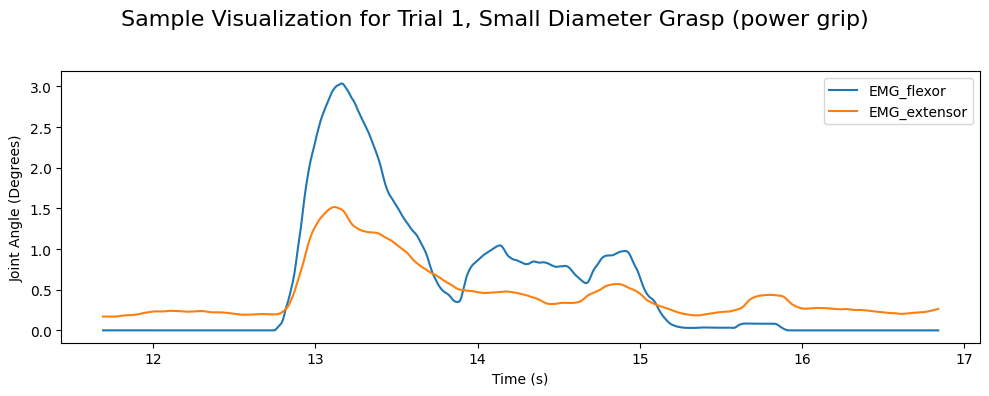

In [468]:
# Visualize RMS signal
ut.visualize_sample(stim_emg_data_pandas, 1, ['EMG_flexor', 'EMG_extensor'])

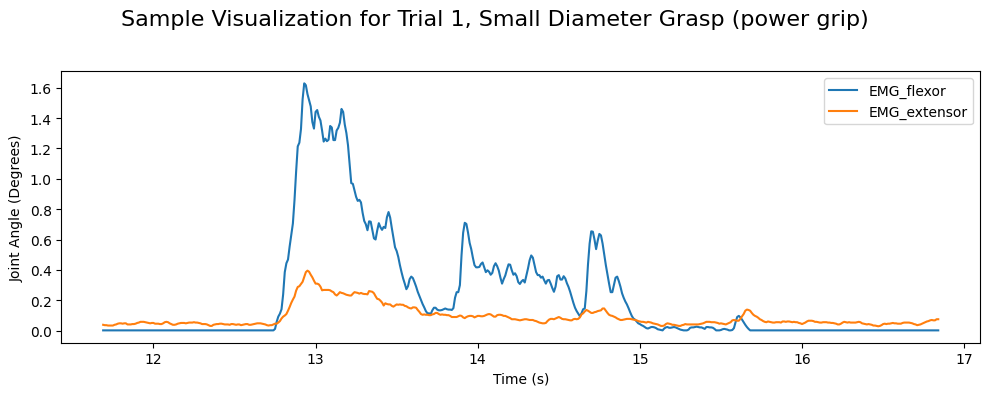

In [24]:
# Visualize raw signal
ut.visualize_sample(segmented_emg_data_raw, 1, ['EMG_flexor', 'EMG_extensor'])

Complete visualization of NEW FILTERING WITH RMS

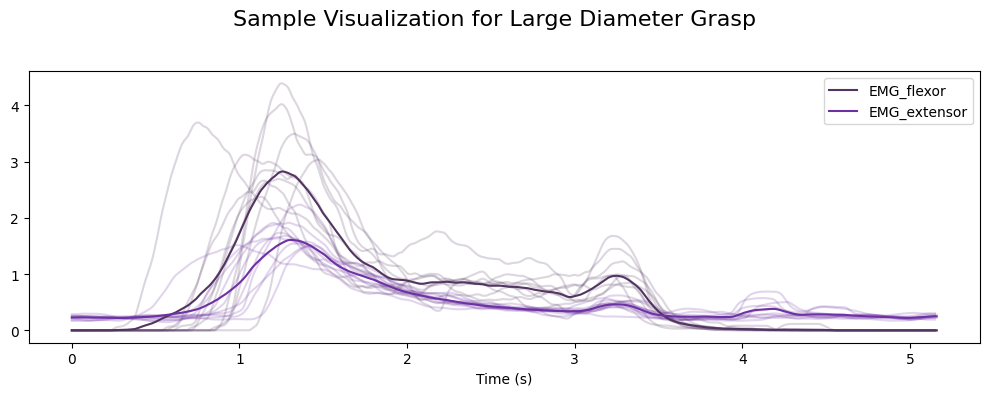

In [469]:
ut.visualize_full_grasp(stim_emg_data_pandas, 1, ['EMG_flexor', 'EMG_extensor'])

Complete visualization of RAW DATA

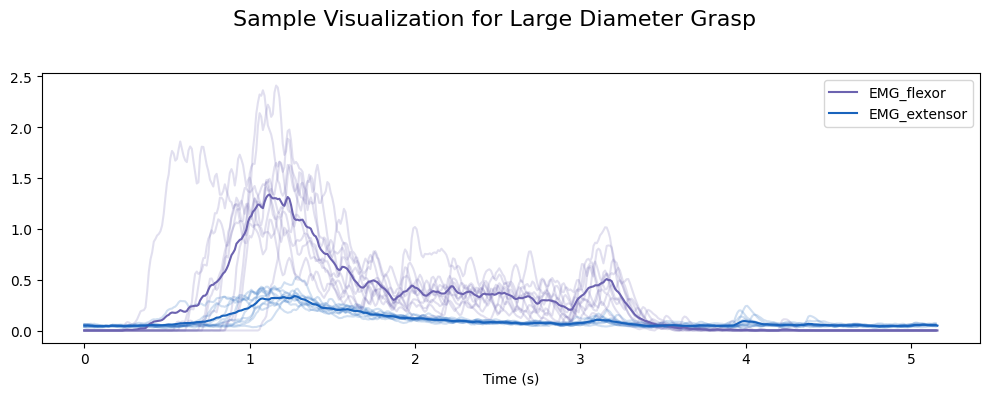

In [26]:
ut.visualize_full_grasp(segmented_emg_data_raw, 1, ['EMG_flexor', 'EMG_extensor'])

Testing an ML model on the RMS filter.

In [425]:
# EMG data: Extract time features along with some frequency domain features.
'''
get_emg_features(emg_data)

Purpose: Extract time-based and frequency-based features for each EMG electrode
measured in Ninapro DB1.
Parameters: segmented EMG data (list of Pandas dataframes)
Output: List of EMG features for each trial (2D list). Each EMG electrode
contributes a MAV (mean absolute value), variance, waveform length, HST
(histogram), and DWT (discrete wavelet transform) to that trial.
'''
def get_new_emg_features(emg_data):
  results = []
  # Loops over each trial
  for trial in emg_data:
    trial_features = []
    for column in trial.columns:
      if column == 'Time':
        continue
      else:
        # Get signal from trial
        signal = trial[column]

        # Calculate MAV, standard deviation, RMS, Log-variance
        mav = float(np.mean(np.abs(signal)))
        stdev = np.sqrt(np.var(signal))
        rms = np.sqrt(np.mean(signal**2))
        logvar = np.log(np.var(signal) + 1e-6)

        # Calcualte waveform length, zero-crossing rate
        waveform_length = float(np.sum(np.abs(np.diff(signal))))
        zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()

        # Calculate slope sign changes, willision amplitude
        ssc = np.sum(np.diff(np.sign(np.diff(signal))) != 0)
        willison_amp = np.sum(np.abs(np.diff(signal)) > 0.01)

        # DWT (discrete wavelet transform)
        dwt = pywt.wavedec(signal, 'db4', level=4)
        dwt_rms = [float(np.sqrt(np.mean(band**2))) for band in dwt]

        # Histogram
        histogram, _ = np.histogram(signal, bins=10, density=True)

        # Converts numpy floats into regular floats
        trial_features.extend([mav, stdev, logvar, rms, waveform_length, zero_crossings, ssc, willison_amp] + histogram.tolist() + dwt_rms[:3])

    results.append(trial_features)
  return results
  '''
  histogram.tolist() + dwt_rms[:3]
  '''

In [359]:
def get_old_emg_features(emg_data):
  results = []
  # Loops over each trial
  for trial in emg_data:
    trial_features = []
    for column in trial.columns:
      if column == 'Time':
        continue
      else:
        # Time-based extracted featuers: MAV (mean absolute value), variance,
        # waveform length, sEMG histogram, zero crossing
        signal = trial[column]
        mav = float(np.mean(np.abs(signal)))
        variance = np.var(signal)
        waveform_length = float(np.sum(np.abs(np.diff(signal))))
        histogram, _ = np.histogram(signal, bins=10, density=True)
        # Frequency domain features: DWT (discrete wavelet transform). may add STFT
        dwt = pywt.wavedec(signal, 'db4', level=4)
        # Take RMS of each band
        dwt_rms = [float(np.sqrt(np.mean(band**2))) for band in dwt]
        # Converts numpy floats into regular floats
        trial_features.extend([mav, variance, waveform_length] + histogram.tolist() + dwt_rms[:3])
    results.append(trial_features)
  return results

  ''' waveform_length, variance, mav
  '''

In [426]:
emg_features = get_old_emg_features(restim_emg_data_pandas)
emg_features_raw = get_new_emg_features(segmented_emg_data_raw)

In [427]:
# Define x (features) and y (labels)
x = emg_features_raw
y = restim_labels

In [428]:
# Split the EMG data into test and training grups using an 80/20 split.
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

In [432]:
# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [433]:
# Random Forest Classifier
emg_rf = RandomForestClassifier(n_estimators=500)
emg_rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=500)

In [434]:
# Test the accuracy of the model
y_predicted = emg_rf.predict(x_test)
accuracy  = accuracy_score(y_test, y_predicted)

# Gets parameters of the model
print(f'Random Forest Accuracy: {accuracy}')
params = emg_rf.get_params()
print('RF Parameters:')
print(params)

Random Forest Accuracy: 0.9347826086956522
RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


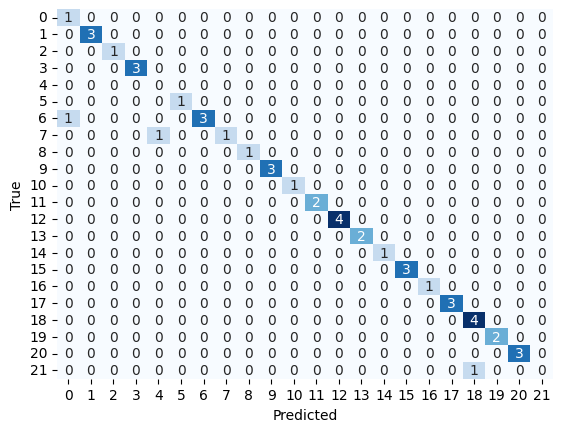

In [396]:
# Seaborn heatmap
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, cmap='Blues', fmt='g',
            cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Combine the EMG data for all participants.

In [473]:
# Create a list of folders with all Ninapro DB1 subjects
ninaproDB1_folder_path = '/content/drive/MyDrive/Grasp Project /Data /Ninapro DB1'
subject_folders = os.listdir(ninaproDB1_folder_path)

In [476]:
'''
get_emg_features_and_labels(subject_folder)

Purpose:
Parameters:
Output:
'''

def get_emg_features_and_labels(subject_folder):

  # Get path for folder
  subject_folder_path = os.path.join(ninaproDB1_folder_path, subject_folder)

  # Find data path for correct file using subject number
  subject_number = ut.find_subject_number(subject_folder)
  subject_data_path = subject_folder_path + f'/S{subject_number}_A1_E3.mat'
  print(f'Processing Subject #{subject_number}...')

  # Extract and filter EMG data from file
  _, subject_emg_data = ut.process_ninapro_subject(subject_data_path, 100)
  #subject_filtered_emg_data = ut.filter_data(subject_emg_data, 100, 'emg')

  # Normalize data
  #subject_normalized_emg_data = normalize_emg_data(subject_filtered_emg_data)

  # Segment data
  subject_restim_data = sio.loadmat(subject_data_path)['restimulus']
  restim_timestamps, restim_labels = ut.gather_restim_timestamps_and_labels(subject_restim_data)
  subject_emg_trials = ut.segment_data(subject_emg_data, restim_timestamps)

  # Extract kinematic features
  subject_emg_features = get_new_emg_features(subject_emg_trials)

  return subject_emg_features, restim_labels

In [477]:
def process_all_subjects_emg(folder_list):
  all_emg_features = []
  all_labels = []
  for folder in folder_list:
    # Skip saved csv files and outliers
    if folder in ['all_kinematic_features.csv', 'all_emg_features.csv',
                  'all_kinematic_labels.csv', 'all_combined_features.csv',
                  'Subject_27', 'all_emg_features_new.csv']:
      continue
    else:
      # Get features
      subject_emg_features, subject_labels = get_emg_features_and_labels(folder)
      all_emg_features.extend(subject_emg_features)
      all_labels.extend(subject_labels)
  print('Done!')
  return all_emg_features, all_labels

all_emg_features, all_labels = process_all_subjects_emg(subject_folders)

Processing Subject #1...
Processing Subject #2...
Processing Subject #3...
Processing Subject #4...
Processing Subject #5...
Processing Subject #6...
Processing Subject #7...
Processing Subject #8...
Processing Subject #9...
Processing Subject #10...
Processing Subject #11...
Processing Subject #12...
Processing Subject #13...
Processing Subject #14...
Processing Subject #15...
Processing Subject #16...
Processing Subject #17...
Processing Subject #18...
Processing Subject #19...
Processing Subject #20...
Processing Subject #21...
Processing Subject #22...
Processing Subject #23...
Processing Subject #24...
Processing Subject #25...
Processing Subject #26...
Done!


In [478]:
# This takes a long time to process! Here I will save all the results as a csv.
ut.features_to_csv(all_emg_features, 'all_emg_features_new.csv')
ut.features_to_csv(all_labels, 'all_kinematic_labels.csv')

In [479]:
# Converts csv files back into useable features data
all_emg_features = ut.csv_to_features('all_emg_features_new.csv')
all_labels = ut.csv_to_features('all_kinematic_labels.csv')

# Train new RF classifier with full EMG database.

In [480]:
# Define x (features) and y (labels)
x = all_emg_features
y = all_labels

In [481]:
# Split into test and training groups. Use an 80/20 split.
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

In [482]:
# Scales the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [485]:
# Create a basic RF classifier
full_emg_rf = RandomForestClassifier(n_estimators=200)
full_emg_rf.fit(x_train, y_train)

# Test the accuracy of the model
y_predicted = full_emg_rf.predict(x_test)
accuracy = accuracy_score(y_test, y_predicted)

# Gets parameters of the model
print(f'Random Forest Accuracy: {accuracy}')
params = full_emg_rf.get_params()
print('RF Parameters:')
print(params)
'''
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
\n{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}\n\nx_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

'''

Random Forest Accuracy: 0.7157190635451505
RF Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


"\n{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}\n\n"

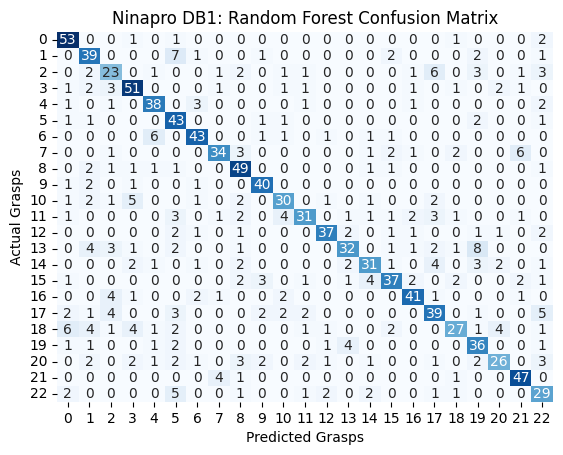

In [486]:
# Visualize the confusion matrix with a Seaborn heatmap
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, cmap='Blues',
            cbar=False)
plt.xlabel('Predicted Grasps')
plt.ylabel('Actual Grasps')
plt.title('Ninapro DB1: Random Forest Confusion Matrix')
plt.show()